Wayne H Nixalo - 4 July 2017 : 00:23 - 20:58

FAI01 - Practical Deep Learning I

Lesson 7: Exotic CNN Architectures - JNB CodeAlong

[L7JNB](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson7.ipynb) | [Lecture 7](https://youtu.be/Q0z-l2KRYFY)

*I'll run this on a tiny sample set Mac-side, before running it on the full set on the Linux machine.*

# Fisheries competition

In this notebook we're going to investigate a range of difference architectures for the [Kaggle Fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/). The video states that `vgg.py` and `vgg_ft()` from `utils.py` have been updated to include VGG with Batch Normalization, but this isn't the case. We've instead created a new file [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py) and an additional method `vgg_ft_bn()` (which is already in `utils.py`) which we use in this notebook.

In [54]:
import theano
%matplotlib inline
import sys, os
sys.path.insert(1, os.path.join('../utils'))
import utils; reload(utils)
from utils import *
from __future__ import print_function, division

/Users/WayNoxchi/Deshar/Kaukasos/FAI/Lesson7


In [56]:
path = "data/fisheries/sample/" # MACOSX
# path = "data/fisheries/" # UBUNTULINUX
# batch_size = 64
batch_size = 32

In [57]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels,
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 400 images belonging to 8 classes.
Found 200 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Found 200 images belonging to 8 classes.
Found 0 images belonging to 0 classes.


Someties it's helpful to have just the filenames, without the path.

In [7]:
raw_filenames      = [f.split('/')[-1] for f in filenames]
# raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames  = [f.split('/')[-1] for f in val_filenames]

----
## I. Setup Dirs:

We create the validation and sample sets in the usual way.

In [6]:
%cd data/fisheries
%cd train
%mkdir ../valid

/Users/WayNoxchi/Deshar/Kaukasos/FAI/data/fisheries
/Users/WayNoxchi/Deshar/Kaukasos/FAI/data/fisheries/train


In [7]:
# makes a copy of each category folder in /valid
g = glob('*')
for d in g: os.mkdir('../valid/' + d)

# move 500 random folder/img pairs from /train to /valid
# not perfectly proportional (closer w/ more imgs)
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

In [8]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [9]:
from shutil import copyfile # copying files requires module import

# make corresponding categ folders in sample dir
g = glob('*')
for d in g:
    os.mkdir('../sample/train/' + d)
    os.mkdir('../sample/valid/' + d)

In [12]:
# copy 400 random folder/img pairs to sample folder (val:200)

# for training set
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid

# for valid set
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])
    
%cd ..

/Users/WayNoxchi/Deshar/Kaukasos/FAI/data/fisheries/valid
/Users/WayNoxchi/Deshar/Kaukasos/FAI/data/fisheries


In [13]:
%mkdir results
%mkdir sample/results
%cd ../..
# %cd data/fisheries

/Users/WayNoxchi/Deshar/Kaukasos/FAI


---
## II. Basic VGG

We start with our usual VGG approach. We'll be using VGG w/ Batch Normalization. We explained how to add batch normalization to VGG in the [imagenet_batchnorm_notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb). VGG with batchnorm is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of `vgg_ft` (our finetuning function) with batch norm called `vgg_ft_bn` in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

### Initial Model

First we create a simple fine-tuned VGG model to be our starting point.

In [58]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

In [27]:
trn = get_data(path + 'train')
val = get_data(path + 'valid')

Found 400 images belonging to 8 classes.
Found 200 images belonging to 8 classes.


In [ ]:
# test = get_data(path + 'test')

In [28]:
save_array(path + 'results/trn.dat', trn)
save_array(path + 'results/val.dat', val)

In [ ]:
# save_array(path + 'results/test.dat', test)

In [107]:
trn = load_array(path + 'results/trn.dat')
val = load_array(path + 'results/val.dat')
# test = load_array(path + 'results/test.dat')

In [59]:
gen = image.ImageDataGenerator()

In [60]:
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 400 samples, validate on 200 samples
Epoch 1/3
400/400 [==============================] - 284s - loss: 4.7394 - acc: 0.2550 - val_loss: 3.0133 - val_acc: 0.4650
Epoch 2/3
400/400 [==============================] - 278s - loss: 3.0591 - acc: 0.4700 - val_loss: 2.0585 - val_acc: 0.5700
Epoch 3/3
400/400 [==============================] - 273s - loss: 2.3945 - acc: 0.5025 - val_loss: 1.8412 - val_acc: 0.5800


In [32]:
model.save_weights(path + 'results/ft1.h5')

### Precompute Convolutional Output

We pre-compute the output of the last convolutional layer of VGG, since we're unlikely to need to fine-tune those layers. (All following analysis will be done on just the pre-computed convolutional features).

In [61]:
# model.load_weights(path + 'results/ft1.h5')

In [62]:
# just took a look at `spli_at(..)` in utils.py; this function's awesome
conv_layers, fc_layers = split_at(model, Convolution2D)

In [34]:
conv_model = Sequential(conv_layers)

In [35]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)
# conv_test_feat = conv_model.predict(test)

# NOTE: looking at MACOSX mem usage, I think Apple does some memory-caching black magic 
# to not hit the machine's memory cap. <3

In [36]:
save_array(path + 'results/conv_feat.dat', conv_feat)
save_array(path + 'results/conv_val_feat.dat', conv_val_feat)
# save_array(paht + 'results/conv_test_feat.dat', conv_test_feat)

In [75]:
conv_feat = load_array(path + 'results/conv_feat.dat')
conv_val_feat = load_array(path + 'results/conv_val_feat.dat')
# conv_test_feat = load_array(path + 'results/conv_test_feat.dat', conv_test_feat)

In [76]:
conv_val_feat.shape

(200, 512, 14, 14)

### Train Model

We can now create our first baseline model - a simple 3-Layer FC Net

In [81]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [82]:
p = 0.6

In [83]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3,
             validation_data=(conv_val_feat, val_labels))

Train on 400 samples, validate on 200 samples
Epoch 1/3
400/400 [==============================] - 2s - loss: 2.6617 - acc: 0.4400 - val_loss: 7.8524 - val_acc: 0.4300
Epoch 2/3
400/400 [==============================] - 2s - loss: 0.5775 - acc: 0.8750 - val_loss: 4.9289 - val_acc: 0.5800
Epoch 3/3
400/400 [==============================] - 2s - loss: 0.3282 - acc: 0.9425 - val_loss: 3.3255 - val_acc: 0.6700


In [43]:
bn_model.optimizer.lr = 1e-4
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7,
             validation_data=(conv_val_feat, val_labels))

Train on 400 samples, validate on 200 samples
Epoch 1/7
400/400 [==============================] - 2s - loss: 0.2161 - acc: 0.9725 - val_loss: 3.0910 - val_acc: 0.6850
Epoch 2/7
400/400 [==============================] - 2s - loss: 0.1559 - acc: 0.9925 - val_loss: 2.8237 - val_acc: 0.6850
Epoch 3/7
400/400 [==============================] - 2s - loss: 0.1600 - acc: 0.9925 - val_loss: 2.4159 - val_acc: 0.7000
Epoch 4/7
400/400 [==============================] - 2s - loss: 0.1487 - acc: 0.9900 - val_loss: 2.0360 - val_acc: 0.7400
Epoch 5/7
400/400 [==============================] - 2s - loss: 0.1418 - acc: 0.9925 - val_loss: 1.8611 - val_acc: 0.7400
Epoch 6/7
400/400 [==============================] - 2s - loss: 0.1449 - acc: 0.9875 - val_loss: 1.6807 - val_acc: 0.7600
Epoch 7/7
400/400 [==============================] - 2s - loss: 0.1457 - acc: 0.9900 - val_loss: 1.4577 - val_acc: 0.7600


In [45]:
bn_model.save_weights(path + 'models/conv_512_6.h5')

In [48]:
bn_model.evaluate(conv_val_feat, val_labels)

192/200 [===========================>..] - ETA: 0s

[1.4577059459686279, 0.76000000000000001]

In [84]:
bn_model.load_weights(path + 'models/conv_512_6.h5')

---
## III. Multi-Input

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we createa arrays of the file sizes for each image:

In [66]:
# creates array of all image sizes
sizes = [PIL.Image.open(path + 'train/' + f).size for f in filenames]
# creates set of image sizes (all unique sizes)
id2size = list(set(sizes))
# creates dictionary of image size to index <-- for one-hotting
size2id = {o:i for i,o in enumerate(id2size)}

In [10]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 22,
         (1244, 700): 4,
         (1276, 718): 22,
         (1280, 720): 230,
         (1280, 750): 62,
         (1280, 924): 9,
         (1280, 974): 43,
         (1518, 854): 4,
         (1732, 974): 4})

Then we One-Hot Encode them (since we want to treat them as categorical) and normalize the data.

In [11]:
# one-hot encode images
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [14]:
trn_sizes_orig[0]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [40]:
# same proc as `sizes` above; for val imgs
raw_val_sizes = [PIL.Image.open(path + 'valid/' + f).size for f in val_filenames]
id2size = list(set(raw_val_sizes))
size2id = {o:i for i,o in enumerate(id2size)}

# one-hot encoding
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [19]:
# aha, this get's the normalized sizes of the images:
# subtract mean, divide by standard deviation
trn_sizes = trn_sizes_orig - trn_sizes_orig.mean(axis=0) / trn_sizes_orig.std(axis=0)
val_sizes = val_sizes - trn_sizes_orig.mean(axis=0) / trn_sizes_orig.std(axis=0)

In [51]:
id2size[:]
size2id
# sizes

{(1192, 670): 3,
 (1244, 700): 1,
 (1276, 718): 5,
 (1280, 720): 4,
 (1280, 750): 0,
 (1280, 924): 8,
 (1280, 974): 6,
 (1334, 750): 2,
 (1518, 854): 7}

To use this additional 'meta-data', we create a model with multiple input layers - `sz_inp` will be our input for the size information.

In [71]:
# input: convolutional layers
inp = Input(conv_layers[-1].output_shape[1:])
# size input
sz_inp = Input((len(id2size),))
# batchnormed size input
bn_inp = BatchNormalization()(sz_inp)

# as usual: convolutional features in:
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
# size input merged in here
x = merge([x, bn_inp], 'concat')
x = Dense(8, activation='softmax')(x)

When we compile the mdoel, we have to specify all the input layers in an array

In [72]:
model = Model([inp, sz_inp], x)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

And when we train the model, we have to provide all the input layers' data in an array:

In [77]:
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size, nb_epoch=3,
             validation_data=([conv_val_feat, val_sizes], val_labels))
# NOTE: this is attempting to take advantage of data leakage

Train on 400 samples, validate on 200 samples
Epoch 1/3
400/400 [==============================] - 4s - loss: 2.3133 - acc: 0.3225 - val_loss: 4.2214 - val_acc: 0.5350
Epoch 2/3
400/400 [==============================] - 4s - loss: 1.3035 - acc: 0.5675 - val_loss: 2.8937 - val_acc: 0.6350
Epoch 3/3
400/400 [==============================] - 4s - loss: 0.8105 - acc: 0.7525 - val_loss: 2.2309 - val_acc: 0.6650


In [86]:
# I think this is comparing multi input model to single input model:
bn_model.optimizer.lr = 1e-4
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=8,
          validation_data=(conv_val_feat, val_labels))

Train on 400 samples, validate on 200 samples
Epoch 1/8
400/400 [==============================] - 3s - loss: 0.1437 - acc: 0.9900 - val_loss: 1.3836 - val_acc: 0.7600
Epoch 2/8
400/400 [==============================] - 2s - loss: 0.1333 - acc: 0.9925 - val_loss: 1.3189 - val_acc: 0.7650
Epoch 3/8
400/400 [==============================] - 3s - loss: 0.1325 - acc: 0.9925 - val_loss: 1.1979 - val_acc: 0.7900
Epoch 4/8
400/400 [==============================] - 3s - loss: 0.1268 - acc: 0.9925 - val_loss: 1.1395 - val_acc: 0.7950
Epoch 5/8
400/400 [==============================] - 2s - loss: 0.1279 - acc: 0.9925 - val_loss: 1.0683 - val_acc: 0.8000
Epoch 6/8
400/400 [==============================] - 2s - loss: 0.1265 - acc: 0.9925 - val_loss: 0.9922 - val_acc: 0.8150
Epoch 7/8
400/400 [==============================] - 3s - loss: 0.1240 - acc: 0.9925 - val_loss: 0.9501 - val_acc: 0.8150
Epoch 8/8
400/400 [==============================] - 3s - loss: 0.1248 - acc: 0.9925 - val_loss: 0.9

*NOTE: this Multi-IO model only outperforms standard BN model in the first few epochs (see first runs of BN Model)*

The model didn't show an improvement by using the leakage, other than in the early epochs. THis is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

---
## IV. Bounding Boxes & Multi Output

### Import / View Bounding Boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them [from here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/25902/complete-bounding-box-annotation). We'll see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image.

In [88]:
# UltraJSON -- "ultra-fast JSON decoder for Python, written in pure C"
import ujson as json

In [89]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [91]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations']) > 0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height'] * x['width'])[-1]
# format of j:
# [
#     {
#         "annotations": [
#             {
#                 "class": "rect",
#                 "height": 89.0,
#                 "width": 355.0,
#                 "x": 512.0,
#                 "y": 162.0
#             },
#             .......
#             .......
#         ],
#         "class": "image",
#         "filename": "img_07825.jpg"
#     },
#     .....
#     .....
# ]

# the files need to be downloaded and placed in `path`/annos/ first

In [92]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [93]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

For any images that have no annotations, we'll create an empt bounding box:

In [94]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [96]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

Finally, we convert the dictionary into an array, and convert the coordiantes to our resized 224x224 images.

In [98]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0] * conv_y
    bb[1] = bb[1] * conv_x
    bb[2] = max(bb[2] * conv_x, 0)
    bb[3] = max(bb[3] * conv_y, 0)
    return bb
# fn creates a list of the largest fish in ea. image & places box arn them

In [99]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)],
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s)
                    for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

Now we can check our work by drawing one of the annotations:

In [145]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)
def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

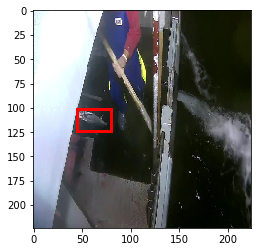

In [146]:
show_bb(0)

### Create & Train Model:

Sicne we're not allowed (by the Kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it'll predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [184]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x) # 4 linear outps w/ no actvtn fn -- bb dims
x_class = Dense(8, activation='softmax', name='class')(x)
# this model'll have to figure out how to come up w/ a bunch of dense layers 
# capable of doing the last 2 lines simultaneously.

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding box loss function down by 1000x, since the scales of the Cross-Entropy Loss and the MSE are very different.

In [185]:
model = Model([inp], [x_bb, x_class]) # optmz: x_bb:mse; x_class:catgXentrop
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[0.001, 1.0]) # scale 1st loss (mse) by 0.001

In [186]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3,
             validation_data=(conv_val_feat, [val_bbox, val_labels]))
# [trn_bbox, trn_labels], <<- use bbs as labels for 1st outp, fish types for 2nd outp

Train on 400 samples, validate on 200 samples
Epoch 1/3
400/400 [==============================] - 3s - loss: 7.3482 - bb_loss: 5082.4582 - class_loss: 2.2658 - bb_acc: 0.3075 - class_acc: 0.3300 - val_loss: 9.0804 - val_bb_loss: 4594.8508 - val_class_loss: 4.4856 - val_bb_acc: 0.2950 - val_class_acc: 0.5400
Epoch 2/3
400/400 [==============================] - 4s - loss: 6.2130 - bb_loss: 5046.3668 - class_loss: 1.1666 - bb_acc: 0.4150 - class_acc: 0.6425 - val_loss: 7.3073 - val_bb_loss: 4475.0151 - val_class_loss: 2.8323 - val_bb_acc: 0.3400 - val_class_acc: 0.5950
Epoch 3/3
400/400 [==============================] - 5s - loss: 5.7803 - bb_loss: 5005.9081 - class_loss: 0.7744 - bb_acc: 0.4725 - class_acc: 0.7225 - val_loss: 6.2659 - val_bb_loss: 4525.1396 - val_class_loss: 1.7407 - val_bb_acc: 0.5500 - val_class_acc: 0.7100


In [187]:
model.optimizer.lr = 1e-5
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10,
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 4s - loss: 5.4208 - bb_loss: 4963.6954 - class_loss: 0.4571 - bb_acc: 0.5375 - class_acc: 0.8575 - val_loss: 5.8941 - val_bb_loss: 4508.5913 - val_class_loss: 1.3855 - val_bb_acc: 0.5350 - val_class_acc: 0.7900
Epoch 2/10
400/400 [==============================] - 3s - loss: 5.2581 - bb_loss: 4914.8382 - class_loss: 0.3432 - bb_acc: 0.5125 - class_acc: 0.8975 - val_loss: 5.7544 - val_bb_loss: 4517.1069 - val_class_loss: 1.2373 - val_bb_acc: 0.5700 - val_class_acc: 0.7350
Epoch 3/10
400/400 [==============================] - 3s - loss: 5.0664 - bb_loss: 4855.9910 - class_loss: 0.2104 - bb_acc: 0.5350 - class_acc: 0.9500 - val_loss: 5.6808 - val_bb_loss: 4511.3537 - val_class_loss: 1.1694 - val_bb_acc: 0.5550 - val_class_acc: 0.7700
Epoch 4/10
400/400 [==============================] - 3s - loss: 4.9731 - bb_loss: 4811.9116 - class_loss: 0.1612 - bb_acc: 0.5250 - class_acc: 0.9700 - val_lo

*NOTE: bb loss is ~1000x larger than class loss. Hense the scaling. Note also its more stable*

Excitingly, it turned out that the classification model is much improved by giving it this additional task. Let's see how well the bounding box model did by taking a look at its output:

In [188]:
# do prediction for 1st 10 validation images
pred = model.predict(conv_val_feat[0:10])

In [189]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

The image shows that it can find fish that are tricky even for us to see!

*although w/ the much smaller sample dataset on the MAC, performance is pretty abysmal on the examples.. but should be v.good on the Linux machine*

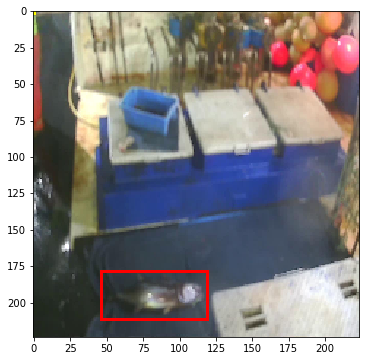

In [190]:
show_bb_pred(6)
# for i in range(40, 50):
#     show_bb_pred(i)

*NOTE: a powerful model will crop out these fish and run them through a second model*

In [193]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

192/200 [===========================>..] - ETA: 0s

[4.708348159790039,
 3983.6346679687499,
 0.72471338987350464,
 0.51000000000000001,
 0.83499999999999996]

In [192]:
model.save_weights(path + 'models/bn_anno.h5')
# model.load_weights(path + 'models/bn_anno.h5')

---
## V. Larger Size

### Set up Data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [194]:
trn = get_data(path + 'train', (360, 640))
val = get_data(path + 'valid', (360, 640))
# remember image dimensions are width x height, but 
# matrix dims are rows X columns; (reversed)

Found 400 images belonging to 8 classes.
Found 200 images belonging to 8 classes.


The image shows that things are much clearer at this size.

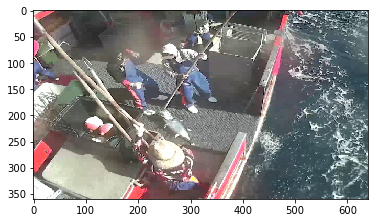

In [195]:
plot(trn[0])

In [ ]:
# test = get_data(path + 'test', (360, 640))

In [196]:
save_array(path + 'results/trn_640.dat', trn)
save_array(path + 'results/val_640.dat', val)
# save_array(path + 'results/test_640.dat', test)

In [ ]:
# trn = load_array(path + 'results/trn_640.dat')
# val = load_array(path + 'results/val_640.dat')

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the Fully-Connected layers (since they don't make sense for non-default sizes). We'll also remove the last Max-Pooling layer, since we don't want to throw away information yet.

In [197]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop() # we don't want the last MaxPooling layer 
# vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])
vgg640.input_shape, vgg640.output_shape

((None, 3, 360, 640), (None, 512, 22, 40))

In [198]:
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

400/400 [==============================] - 1057s   


In [199]:
save_array(path + 'results/conv_val_640.dat', conv_val_feat)
save_array(path + 'results/conv_trn_640.dat', conv_trn_feat)

In [ ]:
# conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

In [275]:
# conv_val_feat = load_array(path + 'results/conv_val_640.dat')
# conv_trn_feat = load_array(path + 'results/conv_trn_640.dat')
# conv_test_feat = load_array(path + 'results/conv_test_640.dat')

---
## VI. Fully Convolutional Net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a *lot* of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem (since the fish are a small part of the image)

In [200]:
conv_layers, _ = split_at(vgg640, Convolution2D)

J.H.: I'm not using any doprout, since I found I got better results without it.

In [201]:
nf = 128; p = 0

In [236]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1, 2)), # (1,2) MxP to trsfm into square result
        Convolution2D(8, 3, 3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [237]:
lrg_model = Sequential(get_lrg_layers())
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_62 (BatchNorm (None, 512, 22, 40)   2048        batchnormalization_input_5[0][0] 
____________________________________________________________________________________________________
convolution2d_52 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_62[0][0]      
____________________________________________________________________________________________________
batchnormalization_63 (BatchNorm (None, 128, 22, 40)   512         convolution2d_52[0][0]           
____________________________________________________________________________________________________
maxpooling2d_33 (MaxPooling2D)   (None, 128, 11, 20)   0           batchnormalization_63[0][0]      
___________________________________________________________________________________________

In [238]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [239]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2,
              validation_data=(conv_val_feat, val_labels))

Train on 400 samples, validate on 200 samples
Epoch 1/2
400/400 [==============================] - 46s - loss: 1.4695 - acc: 0.5050 - val_loss: 5.1408 - val_acc: 0.4200
Epoch 2/2
400/400 [==============================] - 44s - loss: 0.4930 - acc: 0.8525 - val_loss: 2.2223 - val_acc: 0.5800


In [240]:
lrg_model.optimizer.lr=1e-5
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6,
              validation_data=(conv_val_feat, val_labels))

Train on 400 samples, validate on 200 samples
Epoch 1/6
400/400 [==============================] - 41s - loss: 0.1165 - acc: 0.9825 - val_loss: 1.8718 - val_acc: 0.6000
Epoch 2/6
400/400 [==============================] - 40s - loss: 0.0295 - acc: 1.0000 - val_loss: 2.0466 - val_acc: 0.5750
Epoch 3/6
400/400 [==============================] - 44s - loss: 0.0138 - acc: 0.9975 - val_loss: 1.3284 - val_acc: 0.6450
Epoch 4/6
400/400 [==============================] - 37s - loss: 0.0083 - acc: 1.0000 - val_loss: 1.3120 - val_acc: 0.6700
Epoch 5/6
400/400 [==============================] - 38s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.9330 - val_acc: 0.7650
Epoch 6/6
400/400 [==============================] - 40s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.8097 - val_acc: 0.7800


JH: When I submitted the results of this model to Kaggle, I got the best single model results of any shown here (ranked 22nd on the leaderboard as at Dec-6-2016).

In [241]:
lrg_model.save_weights(path + 'models/lrg_nmp.h5')
# lrg_model.load_weights(path + 'models/lrg_nmp.h5')

In [242]:
lrg_model.evaluate(conv_val_feat, val_labels)

200/200 [==============================] - 5s     


[0.8097022318840027, 0.78000000000000003]

Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an Average Pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [243]:
L = lrg_model.layers
conv_fn = K.function([L[0].input, K.learning_phase()], L[-4].output)

In [244]:
def get_cm(inp, label):
    conv = conv_fn([inp, 0])[0, label]
    return scipy.misc.imresize(conv, (360, 640), interp='nearest')

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [245]:
inp = np.expand_dims(conv_val_feat[0],0)
np.round(lrg_model.predict(inp)[0], 2)

array([ 0.96,  0.01,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.01], dtype=float32)

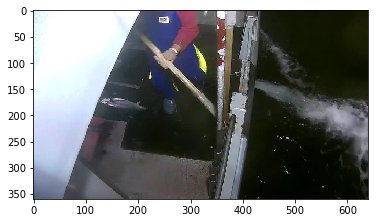

In [246]:
plt.imshow(to_plot(val[0]))

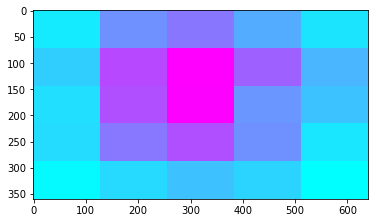

In [247]:
cm = get_cm(inp, 0)
plt.imshow(cm, cmap="cool")

### All Convolutional Net Heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [248]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(8, 3, 3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [249]:
lrg_model = Sequential(get_lrg_layers())
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_66 (BatchNorm (None, 512, 22, 40)   2048        batchnormalization_input_6[0][0] 
____________________________________________________________________________________________________
convolution2d_56 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_66[0][0]      
____________________________________________________________________________________________________
batchnormalization_67 (BatchNorm (None, 128, 22, 40)   512         convolution2d_56[0][0]           
____________________________________________________________________________________________________
convolution2d_57 (Convolution2D) (None, 128, 22, 40)   147584      batchnormalization_67[0][0]      
___________________________________________________________________________________________

In [250]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [251]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2,
              validation_data=(conv_val_feat, val_labels))

Train on 400 samples, validate on 200 samples
Epoch 1/2
400/400 [==============================] - 72s - loss: 1.6837 - acc: 0.4575 - val_loss: 5.3929 - val_acc: 0.4750
Epoch 2/2
400/400 [==============================] - 60s - loss: 1.0025 - acc: 0.7125 - val_loss: 6.1230 - val_acc: 0.4550


In [252]:
lrg_model.optimizer.lr=1e-5
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6,
              validation_data=(conv_val_feat, val_labels))

Train on 400 samples, validate on 200 samples
Epoch 1/6
400/400 [==============================] - 56s - loss: 0.5539 - acc: 0.8700 - val_loss: 2.6663 - val_acc: 0.6000
Epoch 2/6
400/400 [==============================] - 55s - loss: 0.3019 - acc: 0.9375 - val_loss: 3.8461 - val_acc: 0.5100
Epoch 3/6
400/400 [==============================] - 63s - loss: 0.1176 - acc: 0.9825 - val_loss: 1.9946 - val_acc: 0.6600
Epoch 4/6
400/400 [==============================] - 69s - loss: 0.0598 - acc: 0.9900 - val_loss: 2.4425 - val_acc: 0.6200
Epoch 5/6
400/400 [==============================] - 65s - loss: 0.0348 - acc: 1.0000 - val_loss: 1.0066 - val_acc: 0.7950
Epoch 6/6
400/400 [==============================] - 67s - loss: 0.0298 - acc: 0.9950 - val_loss: 1.5774 - val_acc: 0.6900


In [253]:
lrg_model.save_weights(path + 'models/lrg_0mp.h5')
# lrg_model.load_weights(path + 'models/lrg_0mp.h5')

#### Create Heatmap

In [254]:
L = lrg_model.layers
conv_fn = K.function([L[0].input, K.learning_phase()], L[-3].output)

In [255]:
# Resize heatmap to 360 by 640
def get_cm2(imp, label):
    conv = conv_fn([inp, 0])[0, label]
    return scipy.misc.imresize(conv, (360, 640))
# by default, .imresize will try to interpolate; replace big pixels w/ 
# interpolated small pixels

In [256]:
inp = np.expand_dims(conv_val_feat[0], 0)

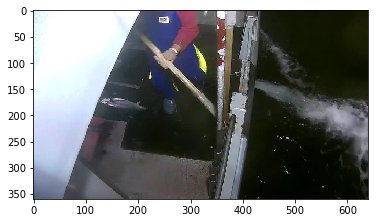

In [257]:
plt.imshow(to_plot(val[0]))

In [260]:
cm = get_cm2(inp, 0)
# cm = get_cm2(inp, 4)

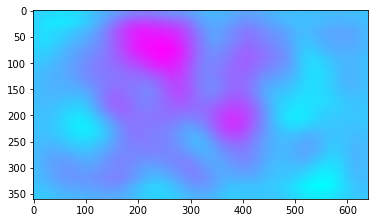

In [261]:
plt.imshow(cm, cmap="cool")

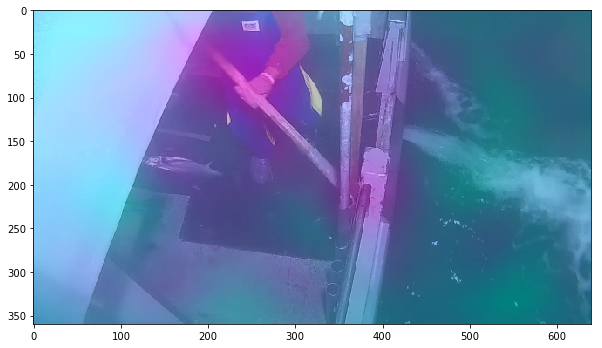

In [262]:
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(cm, cmap="cool", alpha=0.5)

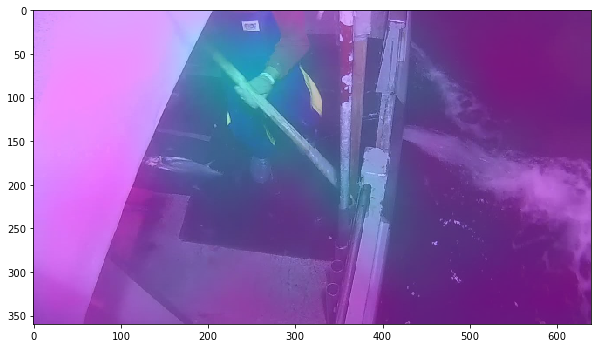

In [265]:
# looking for "No Fish" class:
cm = get_cm2(inp, 4)
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(cm, cmap="cool", alpha=0.5)

*A hand is not a fish, sir. Mmmm Fish Fingers...*

---
## VI. Inception Mini-Net

Here's an example of how to create and use "Inception Blocks" - as you see, they use multiple different convolution filter sizes and concatenate the reusults together. We'll talk more about these next year.

*NOTE: unable to get this working so far. Searched for a similar problem: *

    ValueError: padding must be zero for average_exc_pad 

*and the [author of Keras said](https://github.com/fchollet/keras/issues/4599#issuecomment-296862194) the solution was to use the TensorFlow backend bc it's a Theano issue. The 2nd part of this course apparently uses InceptionV3 within Keras, so I may hold off for a better supported way like that.*

In [279]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1,1)):
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample, activation='relu', border_mode='same')(x)
    return BatchNormalization(axis=1)(x)

def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))
    
    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))
    
    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                mode='concat', concat_axis=1)

In [277]:
inp = Input(vgg640.layers[-1].output_shape[1:])
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8,3,3, border_mode='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

In [278]:
lrg_model = Model([inp], outp)
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2,
              validation_data=(conv_val_feat, val_labels))

Train on 400 samples, validate on 200 samples
Epoch 1/2


ValueError: padding must be zero for average_exc_pad
Apply node that caused the error: AveragePoolGrad{ignore_border=True, mode='average_exc_pad', ndim=2}(Join.0, IncSubtensor{InplaceInc;::, ::, :int64:, :int64:}.0, TensorConstant{(2,) of 3}, TensorConstant{(2,) of 2}, TensorConstant{(2,) of 1})
Toposort index: 1535
Inputs types: [TensorType(float32, 4D), TensorType(float32, 4D), TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector)]
Inputs shapes: [(32, 128, 6, 10), (32, 128, 3, 5), (2,), (2,), (2,)]
Inputs strides: [(30720, 240, 40, 4), (7680, 60, 20, 4), (8,), (8,), (8,)]
Inputs values: ['not shown', 'not shown', array([3, 3]), array([2, 2]), array([1, 1])]
Outputs clients: [[Elemwise{add,no_inplace}(CorrMM_gradInputs{half, (2, 2), (1, 1)}.0, CorrMM_gradInputs{half, (1, 1), (1, 1)}.0, CorrMM_gradInputs{half, (1, 1), (1, 1)}.0, AveragePoolGrad{ignore_border=True, mode='average_exc_pad', ndim=2}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 1271, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 966, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 1271, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 966, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 1271, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 966, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 1271, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 1107, in access_term_cache
    new_output_grads)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

*Copy-Paste from Lesson 7 JNB gives same result*

In [271]:
# def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
#     x = Convolution2D(nb_filter, nb_row, nb_col,
#                       subsample=subsample, activation='relu', border_mode='same')(x)
#     return BatchNormalization(axis=1)(x)

# def incep_block(x):
#     branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
#     branch5x5 = conv2d_bn(x, 24, 1, 1)
#     branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

#     branch3x3dbl = conv2d_bn(x, 32, 1, 1)
#     branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
#     branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

#     branch_pool = AveragePooling2D(
#         (3, 3), strides=(2, 2), border_mode='same')(x)
#     branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
#     return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
#               mode='concat', concat_axis=1)

# inp = Input(vgg640.layers[-1].output_shape[1:]) 
# x = BatchNormalization(axis=1)(inp)
# x = incep_block(x)
# x = incep_block(x)
# x = incep_block(x)
# x = Dropout(0.75)(x)
# x = Convolution2D(8,3,3, border_mode='same')(x)
# x = GlobalAveragePooling2D()(x)
# outp = Activation('softmax')(x)

# lrg_model = Model([inp], outp)

# lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
#              validation_data=(conv_val_feat, val_labels))

Train on 400 samples, validate on 200 samples
Epoch 1/2


ValueError: padding must be zero for average_exc_pad
Apply node that caused the error: AveragePoolGrad{ignore_border=True, mode='average_exc_pad', ndim=2}(Join.0, IncSubtensor{InplaceInc;::, ::, :int64:, :int64:}.0, TensorConstant{(2,) of 3}, TensorConstant{(2,) of 2}, TensorConstant{(2,) of 1})
Toposort index: 1541
Inputs types: [TensorType(float32, 4D), TensorType(float32, 4D), TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector)]
Inputs shapes: [(32, 128, 6, 10), (32, 128, 3, 5), (2,), (2,), (2,)]
Inputs strides: [(30720, 240, 40, 4), (7680, 60, 20, 4), (8,), (8,), (8,)]
Inputs values: ['not shown', 'not shown', array([3, 3]), array([2, 2]), array([1, 1])]
Outputs clients: [[Elemwise{add,no_inplace}(CorrMM_gradInputs{half, (2, 2), (1, 1)}.0, CorrMM_gradInputs{half, (1, 1), (1, 1)}.0, CorrMM_gradInputs{half, (1, 1), (1, 1)}.0, AveragePoolGrad{ignore_border=True, mode='average_exc_pad', ndim=2}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 1271, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 966, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 1271, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 966, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 1271, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 966, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 1271, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/Users/WayNoxchi/Miniconda3/Theano/theano/gradient.py", line 1107, in access_term_cache
    new_output_grads)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
lrg_model.optimizer.lr=1e-5
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6,
              validation_data=(conv_val_feat, val_labels))

In [ ]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=10,
             validation_data=(conv_val_feat, val_labels))

In [ ]:
lrg_model.save_weights(path + 'm')

---
All following code not run:

## VII. Pseudo-Labeling

In [ ]:
preds = model.predict([conv_test_feat, test_sizes], batch_size=batch_size*2)

In [ ]:
gen = image.ImageDataGenerator()

In [ ]:
test_batches = gen.flow(conv_test_feat, preds, batch_size=16)

In [ ]:
val_batches = gen.flow(conv_val_feat, val_labels, batch_Size=4)

In [ ]:
batches = gen.flow(conv_feat, trn_labels, batch_size=44)

In [ ]:
mi = MixIterator([batches, test_batches, val_batches]) # I think that's how it's done?

In [ ]:
bn_model.fit_generator(mi, mi.N, nb_epoch=8, validation_data=(conv_val_feat, val_labels))

---
## VIII. Submit

In [ ]:
def do_clip(arr, mx): return np.clip(arr, (1 - mx) / 7, mx)

In [ ]:
lrg_model.evaluate(conv_val_feat, val_labels, batch_size*2)

In [ ]:
preds = model.predict(conv_test_feat, batch_size=batch_size)

In [ ]:
preds = preds[1]

In [ ]:
test = load_array(path + 'results/test_640.dat')
# test = load_array(path + 'results/test.dat')

In [ ]:
preds = conv_model.predict(test, batch_size=32)

In [ ]:
subm = do_clip(preds, 0.82)

In [ ]:
subm_name = path + 'results/subm_bb.gz'

In [ ]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [ ]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

In [ ]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [ ]:
FileLink(subm_name)